# ECE504 Project 1
Stephen Newberry

In [1]:
import sys
import logging
from timeit import default_timer as timer
from typing import NamedTuple
import numpy as np
import csv
import datetime

# First line, make sure Python is set up/runs
print("Stephen Newberry - Project 1 - ECE504 - Fall 2023")
print(f"Running Python {sys.version}")

logging.basicConfig(format='[%(levelname)s] %(message)s',
                    datefmt='%d/%m/%Y %I:%M:%S %p', level=logging.INFO)

Stephen Newberry - Project 1 - ECE504 - Fall 2023
Running Python 3.10.13 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:24:38) [MSC v.1916 64 bit (AMD64)]


In [2]:
# Import Simbeor for Field Solver
sys.path.append("C:/Users/steph/Documents/Education/CLASS06_2023F_ECE504/projects/project1/code")
from simbeor_sdk import simbeor
if not simbeor.Initialize():
    logging.warning("Error initializing Simbeor")

if not simbeor.SetLicense(
        'C:\\Users\\steph\\Documents\\ShieldDigitalDesign\\Software\\Licenses', 'simbeor_verify'):
    logging.warning("Error setting Simbeor license")


## Substrate Design

The substrate will be a standard, uncoated microstrip. The metal will be 1.2mil thick (standard 1oz Cu after processing). Conductivity will use the ideal value of 5.8E+06 S/m for copper. 
The dielectric will be modeled after Isola FR408HR, which is a standard dielectric used for low- to medium-speed digital PCB applications.
https://www.isola-group.com/pcb-laminates-prepreg/fr408hr-laminate-and-prepreg/
We will use the dielectric values from an 8mil, 2x3313 weave, 55% resin content, core material. It has a Dk/Df of 3.68/0.0087 at 1 GHz.

Copper roughness will not be modeled, nor will trace etch-back (rectangular cross-section).

In [3]:
# Configure substrate
cu_thickness = 1.2 #mils
diel_thickness = 8.0 #mils
dk = 3.68
df = 0.0087
cu_cond = 5.80046403712e6 #S/m

# NOTE: Ignoring roughness

simbeor.ProjectDelete("TLINE")  # In case it exists, delete
model_name = "tline_model"
prj = simbeor.ProjectCreate("TLINE", True, True, 25.0)
if (prj == 0):
    logging.error("Project exists, delete project first")

# Configure frequency sweep
freq_sweep = simbeor.InitFrequencySweep()
freq_sweep['SweepType'] = 'Tabulated'
freq_sweep['Start'] = 1 # GHz
freq_sweep['Stop'] = 1 # GHz

# Add materials to project
# Air
air = simbeor.MaterialAddDielectric("TLINE\\Air", 1.0, 0.0, 1e9, 0, 1e4, 1e12)
if (air == 0):
    logging.error("Error creating air")
# Conductor
rel_res = (1/cu_cond)/1.724e-8
cond = simbeor.MaterialAddConductor("TLINE\\Copper", rel_res, 0, 0.004)
if (cond == 0):
    logging.error("Error creating conductor")
# Dielectric
diel = simbeor.MaterialAddDielectric(
    "TLINE\\Dielectric", dk, df, 1e9, 0, 1e4, 1e12)
if (diel == 0):
    logging.error("Error creating dielectric")

# Create Stackup (top to bottom)
layer1 = simbeor.LayerAddSignal("TLINE\\L1", "Copper", "Air", simbeor.mil_to_m(cu_thickness))
if (layer1 == 0):
    logging.error("Error creating stackup Layer 1")
diel1 = simbeor.LayerAddMedium("TLINE\\DIEL", "Dielectric", simbeor.mil_to_m(diel_thickness))
if (diel1 == 0):
    logging.error("Error creating stackup dielectric")
layer2 = simbeor.LayerAddCover("TLINE\\L2", "Copper", simbeor.mil_to_m(0.1))


In [4]:
# Set up a Named Tuple as output
class SimResult(NamedTuple):
    z0: float # Ohms
    e_length: float # Degrees
    exec_time: float # Seconds

# Define field-solver simulation
def simulate_tline(width, length) -> SimResult:
    """Takes input geometry of t-line and returns tuple containing Z0 (Ohms) and electrical length (deg). 
    Also returns execution time in seconds

    :param width: trace width of the input line in mils 
    :param length: length of the transmission line in mils
    """
    # T-Line
    tline = simbeor.InitSingleTLine()
    tline['Width'] = simbeor.mil_to_m(width)
    tline['StripShape'] = "Rectangular"
    tline['EtchFactor'] = 0  # No etch factor
    tline['Clearance'] = 0.0  # Set to zero for no coplanar ground
    tline['LayerName'] = "L1"
    tline['BottomRefLayer'] = "L2"

    simbeor.ModelDelete(model_name) # In case it exists
    # Also, would like to time this specific function and record it
    ##### MAIN SIMBEOR FUNCTION ######
    start_time = timer()
    results = simbeor.ModelSingleTLine_SFS(model_name, tline, freq_sweep, 0)
    end_time = timer()
    #logging.info(f"Simbeor function elapsed time: {end_time-start_time} seconds")
    ##################################
    
    exec_time = end_time - start_time
    
    z0 = simbeor.GetCharacteristicImpedances(model_name, 50, 1)[0]
    
    # 1 radian/meter is 0.001455 deg per mil

    e_length_rad_per_meter = simbeor.GetPropagationConstants(model_name, "PhaseConstant",1)[0]
    e_length = e_length_rad_per_meter * 0.001455 * length
    
    sim_result = SimResult(
        z0=z0,
        e_length=e_length,
        exec_time=exec_time
    )
    # logging.info(f"For inputs {width}, {length}\nResult: {sim_result}\n")
    return sim_result


In [5]:
# Example
simulate_tline(width=15, length=10000)

SimResult(z0=53.932050940424055, e_length=514.1561593970865, exec_time=0.0012434999807737768)

## Training Data
Training data will be a Pandas dataframe. Each row is an instance. It will have the following columns:

* Trace width, mils (input)
* Trace length, mils (input)
* Z0 at 1 GHz, ohms (output)
* Electrical length at 1 GHz, degrees (output)
* Execution time

A typical microwave trace will be anywhere from 4mil upwards of 25mil or so on a PCB, but since we're fixing our substrate at 8mil thickness, that means we'd want to center on ~16mil for a 50ohm line. For length, we'll use 6" as a mean with a Rayleigh distribution.

Actually.... this distribution kinda sucks. Uniform for now...
wait, lognormal!


In [6]:
import pandas as pd

# Next, we need to generate the training data
generate_new_training_data = False
num_training_points = 1000000
num_validation_points = int(np.floor(.2 * num_training_points))
num_test_points = int(np.floor(0.2 * num_training_points))

if generate_new_training_data:
    timestamp = datetime.datetime.now()
    timestamp_str = f"{timestamp.year}_{timestamp.month}_{timestamp.day}_{timestamp.time().hour}{timestamp.time().minute}{timestamp.time().second}"
    print(f"Generating data as of {timestamp}")
    
    if generate_new_training_data:
        # Create blank CSV
        fields = ['width', 'length', 'z0', 'e_length', 'exec_time']
    
        # Min/Max ranges
        trace_width_min = 0.1 # mil
        trace_width_max = 500.0
        trace_width_mean = 16.0
        trace_length_min = 1 # mil
        trace_length_max = 100000 # 100 inches
        trace_length_mean = 6000
        
        # Lognormal settings
        sigma = 0.75
    
        train = pd.DataFrame(columns=fields)
        for i in range(num_training_points):
            width = np.random.lognormal(sigma=sigma, mean=np.log(trace_width_mean))
            length = np.random.lognormal(sigma=sigma, mean=np.log(trace_length_mean))
            
            sim_result = simulate_tline(width,length)
            
            # Assign the result values
            z0 = sim_result.z0
            e_length = sim_result.e_length
            exec_time = sim_result.exec_time
            
            new_row = pd.DataFrame([[width, length, z0, e_length, exec_time]], columns=fields)
            
            train = pd.concat([train, new_row], ignore_index=True)
        train.to_csv(f'./training_data/{timestamp_str}_train.csv')
    
        # Probably should have this be some kind of function. Later :)
        val = pd.DataFrame(columns=fields)
        for i in range(num_validation_points):
            width = np.random.lognormal(sigma=sigma, mean=np.log(trace_width_mean))
            length = np.random.lognormal(sigma=sigma, mean=np.log(trace_length_mean))
        
            sim_result = simulate_tline(width,length)
        
            # Assign the result values
            z0 = sim_result.z0
            e_length = sim_result.e_length
            exec_time = sim_result.exec_time

            new_row = pd.DataFrame([[width, length, z0, e_length, exec_time]], columns=fields)

            val = pd.concat([val, new_row], ignore_index=True)
        val.to_csv(f'./training_data/{timestamp_str}_val.csv')

        test = pd.DataFrame(columns=fields)
        for i in range(num_test_points):
            width = np.random.lognormal(sigma=sigma, mean=np.log(trace_width_mean))
            length = np.random.lognormal(sigma=sigma, mean=np.log(trace_length_mean))
        
            sim_result = simulate_tline(width,length)
        
            # Assign the result values
            z0 = sim_result.z0
            e_length = sim_result.e_length
            exec_time = sim_result.exec_time

            new_row = pd.DataFrame([[width, length, z0, e_length, exec_time]], columns=fields)

            test = pd.concat([test, new_row], ignore_index=True)
        test.to_csv(f'./training_data/{timestamp_str}_test.csv')
    
    
# Took 2.25hrs to train 1M points

[INFO] Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
[INFO] NumExpr defaulting to 8 threads.


In [7]:
# Next, train the model

import torch
import torch.nn as nn
import timeit

# Check devices
# if torch.cuda.is_available():
#     logging.info("Using CUDA....")
    
# Use this line to set a preferred set of data
# Otherwise, it uses the one generated above

timestamp_str = "2023_10_2_212631"

if timestamp_str is None:
    timestamp_str = "2023_10_2_212631"
    
# Re-read to dataframes
training_data_df = pd.read_csv(f'./training_data/{timestamp_str}_train.csv')
val_data_df = pd.read_csv(f'./training_data/{timestamp_str}_val.csv')
test_data_df = pd.read_csv(f'./training_data/{timestamp_str}_test.csv')

# Friendly data format
training_input = []
for i in range(len(training_data_df.index)):
    training_input.append([training_data_df['width'].iloc[i], training_data_df['length'].iloc[i]])
training_input_t = torch.tensor(training_input)

training_output = []
training_output_z0 = []
training_output_el = []
for i in range(len(training_data_df.index)):
    training_output.append([training_data_df['z0'].iloc[i], training_data_df['e_length'].iloc[i]])
    training_output_z0.append([training_data_df['z0'].iloc[i]])
    training_output_el.append([training_data_df['e_length'].iloc[i]])
training_output_t = torch.tensor(training_output)
training_output_z0_t = torch.tensor(training_output_z0)
training_output_el_t = torch.tensor(training_output_el)

val_input = []
for i in range(len(val_data_df.index)):
    val_input.append([val_data_df['width'].iloc[i], val_data_df['length'].iloc[i]])
val_input_t = torch.tensor(val_input)

val_output = []
val_output_z0 = []
val_output_el = []
for i in range(len(val_data_df.index)):
    val_output.append([val_data_df['z0'].iloc[i], val_data_df['e_length'].iloc[i]])
    val_output_z0.append([val_data_df['z0'].iloc[i]])
    val_output_el.append([val_data_df['e_length'].iloc[i]])   
val_output_t = torch.tensor(val_output)
val_output_z0_t = torch.tensor(val_output_z0)
val_output_el_t = torch.tensor(val_output_el)

test_input = []
for i in range(len(test_data_df.index)):
    test_input.append([test_data_df['width'].iloc[i], test_data_df['length'].iloc[i]])
test_input_t = torch.tensor(test_input)

test_output = []
test_output_z0 = []
test_output_el = []
for i in range(len(test_data_df.index)):
    test_output.append([test_data_df['z0'].iloc[i], test_data_df['e_length'].iloc[i]])
    test_output_z0.append([test_data_df['z0'].iloc[i]])
    test_output_el.append([test_data_df['e_length'].iloc[i]])
test_output_t = torch.tensor(test_output)
test_output_z0_t = torch.tensor(test_output_z0)
test_output_el_t = torch.tensor(test_output_el)

# if torch.cuda.is_available():
#     training_input_t = training_input_t.to('cuda')
#     training_output_t = training_output_t.to('cuda')
#     val_input_t = val_input_t.to('cuda')
#     val_output_t = val_output_t.to('cuda')
#     # test_input_t = test_input_t.to('cuda')
#     # test_output_t = test_output_t.to('cuda')
#     print(f"Data located at: {training_input_t.device}")
#     # print(training_input_t.device)
#     print(training_output_t.device)
#     print(val_input_t.device)
#     print(val_output_t.device)
#     print(test_input_t.device)
#     print(test_output_t.device)


In [8]:
# Create a scaler for sequential model

class MinMaxScalerLayer(nn.Module):
    def __init__(self, input_size):
        super(MinMaxScalerLayer, self).__init__()
        self.register_buffer('min_vals', torch.zeros(input_size))
        self.register_buffer('max_vals', torch.ones(input_size))

    def forward(self, x):
        # Scale the input to the range [0, 1]
        scaled_x = (x - self.min_vals) / (self.max_vals - self.min_vals)
        return scaled_x

    def inverse_scale(self, scaled_x):
        # Inverse scale the input to the original range
        return scaled_x * (self.max_vals - self.min_vals) + self.min_vals


In [208]:
# Create my model

class TlineModel(nn.Module):
    def __init__(self):
        super(TlineModel, self).__init__()
        self.model = nn.Sequential(
            MinMaxScalerLayer(2),
            # nn.Linear(2, 512),  
            # nn.Tanh(),
            # nn.Linear(512, 64),  
            # nn.ReLU(),
            # nn.Linear(64, 320),
            # nn.ReLU(),
            # nn.Linear(320, 224),
            # nn.ReLU(),
            # nn.Linear(224, 448),
            # nn.ReLU(),
            # nn.Linear(448, 2)  
            nn.Linear(2, 224),
            nn.ELU(),
            nn.Linear(224, 64),
            nn.Softplus(),
            nn.Linear(64, 64),
            # nn.ReLU(),
            nn.Linear(64, 320),
            nn.ReLU(),
            nn.Linear(320, 2),
            nn.ReLU()
        )

    def forward(self, x):
        # Try adding log output?
        # x_log = torch.log(torch.abs(self.model(x)+1e-5))
        return self.model(x)
        # return x_log

In [209]:
model = None

In [245]:
from torch.utils.data import DataLoader, TensorDataset
torch.set_default_dtype(torch.float64)
train_new_model = True

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if train_new_model:
    model = None
    model = TlineModel().to(device)
    
    #Set batch size: 
    batch_size=10000
    
    # Create datasets
    training_dataset = TensorDataset(training_input_t.to(device), training_output_t.to(device))
    val_dataset = TensorDataset(val_input_t.to(device), val_output_t.to(device))
    
    training_data_loader = DataLoader(training_dataset, batch_size = batch_size, shuffle=True)
    val_data_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Define the loss function and optimizer
    criterion = nn.MSELoss()  # Mean Squared Error Loss
    optimizer = torch.optim.Rprop(model.parameters(), lr=0.001)

    # Define weights for each output
    weight_output_z0 = 3.0  # Adjust this weight based on importance
    weight_output_el = 1.0  # Adjust this weight based on importance
    
    # Train
    losses = []
    val_losses = []
    epochs = 10
    for epoch in range(epochs):
        # print(f"\nRunning Epoch {epoch}\n")
        model.train()
        
        for inputs, targets in training_data_loader:
            # print(f"\nRunning TDL {inputs[0]}\n")
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            # loss = criterion(outputs, targets)
            # Weighted loss
            loss = weight_output_z0 * criterion(outputs[:, 0], targets[:, 0]) + weight_output_el * criterion(outputs[:, 1], targets[:, 1])
            losses.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        # Validate
        model.eval()
        with torch.no_grad():
            for val_inputs, val_targets in val_data_loader:
                # print(f"\nRunning VDL {val_inputs[0]}\n")
                val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)  # Move data to GPU
                val_outputs = model(val_inputs)
                # val_loss = criterion(val_outputs, val_targets)
                # Weighted loss
                val_loss = weight_output_z0 * criterion(val_outputs[:, 0], val_targets[:, 0]) + weight_output_el * criterion(val_outputs[:, 1], val_targets[:, 1])
                val_losses.append(val_loss.item())

        # print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')
        print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {sum(losses)/len(losses):.4f}, Validation Loss: {sum(val_losses)/len(val_losses):.4f}')
        
        
# Name and Value after 25 epoch, LR=0.01 for all, using huber loss
# Adadelta          100.2, pred bad
# Adagrad           69, bad
# Adam              53, bad
# AdamW             32, bad
# SparseAdam        x
# Adamax            66 bad
# ASGD              16 really bad
# LBFGS             x
# NAdam             100 bad
# RADAM             gigantic number
# RMSprop           96 bad negative
# Rprop             36 least bad?
# SGD               53 bad


Using device: cuda
Epoch [1/10], Training Loss: 309516.8552, Validation Loss: 309389.6156


KeyboardInterrupt: 

In [211]:
with torch.no_grad():
    predictions = model(test_input_t.to(device)).to(device)
    print("Predictions:")
    print(predictions)
    
print(test_output_t.to(device))

Predictions:
tensor([[  52.2583,  754.3062],
        [  97.1017,  271.7640],
        [ 103.5728, 1008.9057],
        ...,
        [  54.6247,  116.3961],
        [  81.0473,  787.7940],
        [  36.0629,  693.3220]], device='cuda:0')
tensor([[  53.2770,  751.5713],
        [  98.3075,  272.8990],
        [ 103.3895, 1009.8720],
        ...,
        [  53.8333,  117.4296],
        [  80.1476,  787.7499],
        [  37.5190,  693.7832]], device='cuda:0')


In [251]:
predictions = None

In [253]:
# Check time to predict all values
start_time = timer()
predictions = model(test_input_t.to(device)).to(device)
end_time = timer()
total_time = end_time-start_time
time_per_predict = total_time/len(test_input_t)
print(f"Time to predict all: {total_time} seconds")
print(f"Number of Samples: {len(test_input_t)}")
print(f"Time per Sample: {time_per_predict*1e9} ns")

Time to predict all: 0.002008399984333664 seconds
Number of Samples: 200000
Time per Sample: 10.041999921668321 ns


In [244]:
# Some Spot Predictions

twidth = 91.5
tlength = 34433.

check = torch.tensor([[twidth, tlength]]).to(device)
# preds = model(test_input_t[0].to(device)).to(device)
preds = model(check)
pred_z0 = preds[0][0].item()
pred_el= preds[0][1].item()

sims = simulate_tline(twidth, tlength)

print(f"Predict: {pred_z0, pred_el}")
print(f"Simulate: {sims.z0, sims.e_length}")


Predict: (12.71469610629463, 1920.3919580145105)
Simulate: (14.488317257057858, 1922.240220706324)


In [241]:
training_data_df.describe(percentiles=[0.01, 0.1,0.9,0.99])


,Unnamed: 0,width,length,z0,e_length,exec_time
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,499999.500000,21.169422,7953.009622,53.892116,411.539366,0.000982
std,288675.278933,18.403874,6922.440109,21.448189,358.530793,0.000067
min,0.000000,0.356985,135.847705,3.038179,7.098624,0.000871
1%,9999.990000,2.786135,1043.336483,14.487946,53.965567,0.000892
10%,99999.900000,6.115408,2294.636145,27.264294,118.570721,0.000907
50%,499999.500000,15.977290,5998.074000,52.009800,310.305802,0.000978
90%,899999.100000,41.805797,15702.668714,83.101099,812.803701,0.001052
99%,989999.010000,91.502748,34433.629336,108.854294,1782.817863,0.001180
max,999999.000000,499.219254,190691.811237,168.013554,9489.627757,0.004772


In [213]:
torch.tensor([[tlength, twidth]]).to(device)

tensor([[6000.,   40.]], device='cuda:0')

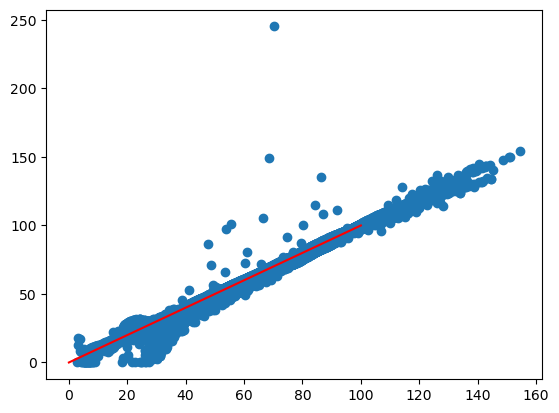

In [214]:
from matplotlib import pyplot as plt
# plt.scatter(test_data_df['width'],test_output_z0)

plot_x = test_output_z0
plot_y = predictions[:,0].cpu()
plt.scatter(plot_x, plot_y)
plt.plot([0,100],[0,100],'r')

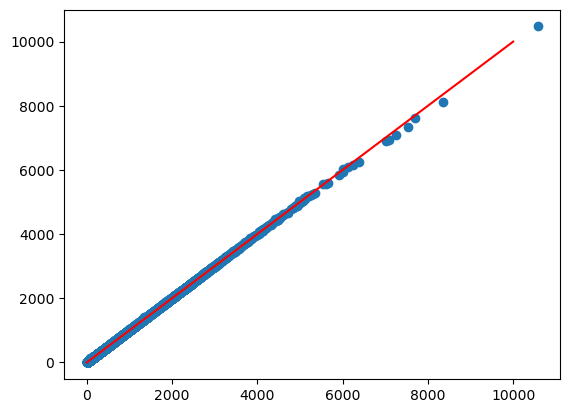

In [215]:
plot_x = test_output_el
plot_y = predictions[:,1].cpu()
plt.scatter(plot_x, plot_y)
plt.plot([0,10000],[0,10000],'r')

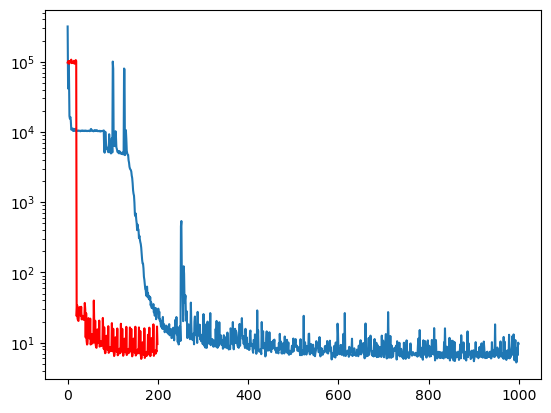

In [216]:
plt.semilogy(losses)
plt.semilogy(val_losses, 'r')

In [194]:
print(training_input_t[:,0])
print(training_output_t[:,0])
print(model)

tensor([31.8182, 18.6971,  7.7771,  ..., 10.2487, 24.1844, 40.0780])
tensor([33.2976, 47.3517, 75.0781,  ..., 66.0097, 40.1918, 28.1419])
TlineModel(
  (model): Sequential(
    (0): MinMaxScalerLayer()
    (1): Linear(in_features=2, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=64, bias=True)
    (4): ReLU()
    (5): Linear(in_features=64, out_features=320, bias=True)
    (6): ReLU()
    (7): Linear(in_features=320, out_features=224, bias=True)
    (8): ReLU()
    (9): Linear(in_features=224, out_features=448, bias=True)
    (10): ReLU()
    (11): Linear(in_features=448, out_features=2, bias=True)
  )
)


In [195]:
    # New timestamp for trained models
    # timestamp = datetime.datetime.now()
    # timestamp_str = f"{timestamp.year}_{timestamp.month}_{timestamp.day}_{timestamp.time().hour}{timestamp.time().minute}{timestamp.time().second}"
    timestamp = timestamp_str
    print(f"Saving model as of {timestamp}")
    
    torch.save(model, f"./models/{timestamp_str}.pt")
    outfile = f"./models/losses/{timestamp_str}_loss"
    # np.save(outfile, losses)
    outfile = f"./models/losses/{timestamp_str}_val_loss"
    # np.save(outfile, val_losses)

    import matplotlib.pyplot as plt
    plt.plot(losses, label="Training Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.ylabel('MSE Loss')
    plt.xlabel('Epoch Number')
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.savefig(f"./models/losses/{timestamp_str}_loss_plot.pdf")
    plt.clf()



Saving model as of 2023_10_2_212631


<Figure size 640x480 with 0 Axes>

In [132]:
device = torch.device('cpu')
model = torch.load(f"./models/{timestamp_str}.pt", map_location=device)
# Move test input to cpu
# test_input_c = test_input_t.to('cpu')
model_predicted = model(test_input_t).detach().numpy()


In [167]:
model.eval()
model(test_input_t)


tensor([[  56.4671,  755.6115],
        [  21.3110,  286.3589],
        [  79.5958, 1061.6104],
        ...,
        [   8.5562,  118.2415],
        [  61.1580,  816.8117],
        [  50.6188,  679.4067]], grad_fn=<CatBackward0>)

In [168]:
# Example of predictions
print(model(torch.tensor([[16,1000],[45.5,321]])))

print(simulate_tline(16,1000))
print(simulate_tline(45.5,321))




tensor([[ 3.5540, 51.8322],
        [ 0.5941, 16.5921]], grad_fn=<CatBackward0>)
SimResult(z0=51.966864432492194, e_length=51.56354045282911, exec_time=0.001576300011947751)
SimResult(z0=25.564457438711788, e_length=17.396382103352234, exec_time=0.001191000104881823)


In [ ]:
# Simbeor Cleanup
simbeor.ReleaseLicense()
simbeor.Cleanup()
simbeor.Uninitialize()